## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

改进方法 获得准确率 提升
基本神经网络 69.36% -
+数据增强 80.42% 11.06%
+模型改进 85.72% 16.36%
+变化学习率 86.24% 16.88%
+深度残差网络 91.55% 22.19%

In [3]:
from google.colab import files
upload = files.upload()

Saving resnet_builder.py to resnet_builder.py


In [4]:
!ls

resnet_builder.py  sample_data


In [0]:
import keras
from keras.datasets import cifar10
from resnet_builder import resnet # 這是從 resnet_builder.py 中直接 import 撰寫好的 resnet 函數
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [25]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [29]:
# 建立 ResNet 模型
keras.backend.clear_session() # 把舊的 Graph 清掉
model = resnet(input_shape=(32,32,3)) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [30]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
epochs = 50 # 訓練整個資料集共 50個循環

results = {}
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

#透過資料擴增, 可以提升準確度
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
model.fit_generator(
        augment_generator.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
        epochs=epochs,
        verbose=1, #verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
        validation_data=(x_test, y_test))

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
    
exp_name_tag = "exp" 
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
781/781 [==============================] - 63s 81ms/step - loss: 1.8945 - acc: 0.4882 - val_loss: 1.9488 - val_acc: 0.4829
Epoch 2/50
781/781 [==============================] - 55s 71ms/step - loss: 1.4295 - acc: 0.6178 - val_loss: 1.3931 - val_acc: 0.6282
Epoch 3/50
781/781 [==============================] - 56s 72ms/step - loss: 1.2445 - acc: 0.6709 - val_loss: 1.4575 - val_acc: 0.6193
Epoch 4/50
781/781 [==============================] - 57s 73ms/step - loss: 1.1137 - acc: 0.7113 - val_loss: 1.2816 - val_acc: 0.6575
Epoch 5/50
781/781 [==============================] - 57s 73ms/step - loss: 1.0237 - acc: 0.7372 - val_loss: 1.2786 - val_acc: 0.6842
Epoch 6/50
781/781 [==============================] - 55s 71ms/step - loss: 0.9576 - acc: 0.7608 - val_loss: 1.3870 - val_acc: 0.6526
Epoch 7/50
781/781 [==============================] - 50s 64ms/step - loss: 0.9069 - acc: 0.7759 - val_loss: 1.2845 - val_acc: 0.6793
Epoch 8/50
781/781 [==============================] - 49s 63ms

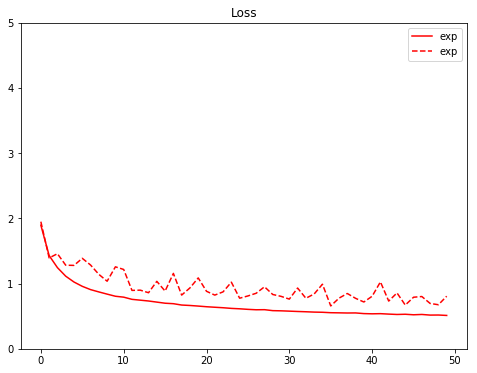

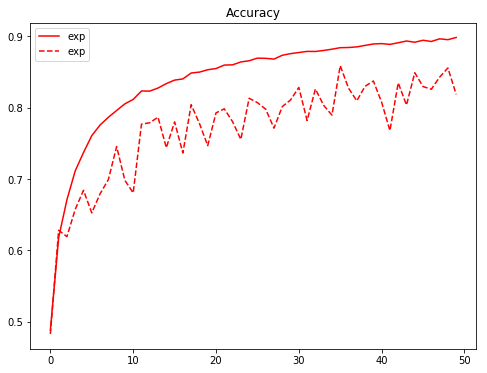

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [35]:
# 建立 ResNet 模型
keras.backend.clear_session() # 把舊的 Graph 清掉
model = resnet(input_shape=(32,32,3)) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [36]:
batch_size =128 # batch 的大小，如果出現 OOM error，請降低這個值; 64 -> 128
epochs = 100 # 訓練整個資料集共 100個循環 ; 50 -> 100, 次數增加, 也可以提升準確度

results = {}
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

#透過資料擴增, 可以提升準確度
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
model.fit_generator(
        augment_generator.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
        epochs=epochs,
        verbose=1, #verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
        validation_data=(x_test, y_test))

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
    
exp_name_tag = "exp" 
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
390/390 [==============================] - 42s 108ms/step - loss: 1.9509 - acc: 0.4784 - val_loss: 1.7894 - val_acc: 0.5161
Epoch 2/100
390/390 [==============================] - 35s 89ms/step - loss: 1.4864 - acc: 0.6190 - val_loss: 1.6170 - val_acc: 0.5724
Epoch 3/100
390/390 [==============================] - 35s 90ms/step - loss: 1.2947 - acc: 0.6705 - val_loss: 1.3022 - val_acc: 0.6692
Epoch 4/100
390/390 [==============================] - 35s 90ms/step - loss: 1.1542 - acc: 0.7141 - val_loss: 1.2659 - val_acc: 0.6891
Epoch 5/100
390/390 [==============================] - 35s 90ms/step - loss: 1.0579 - acc: 0.7418 - val_loss: 1.4499 - val_acc: 0.6284
Epoch 6/100
390/390 [==============================] - 35s 90ms/step - loss: 0.9824 - acc: 0.7646 - val_loss: 1.4791 - val_acc: 0.6532
Epoch 7/100
390/390 [==============================] - 35s 89ms/step - loss: 0.9263 - acc: 0.7798 - val_loss: 1.1335 - val_acc: 0.7258
Epoch 8/100
390/390 [==============================] -

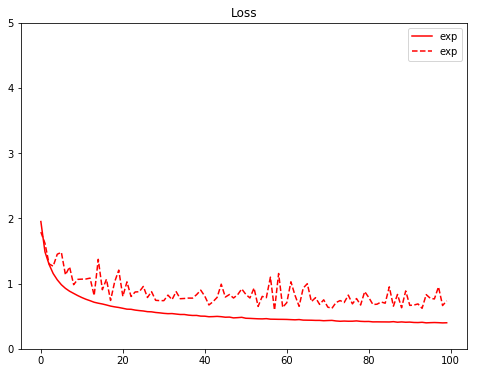

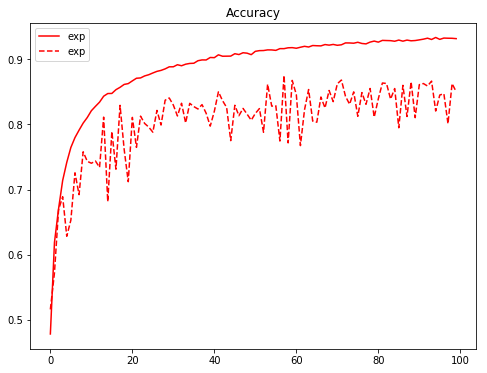

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()